# Credit Card Fraud Detection Predictive Models
## Introduction
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

Due to confidentiality issues, there are not provided the original features and more background information about the data.

- Features V1, V2, ... V28 are the principal components obtained with PCA;
- The only features which have not been transformed with PCA are Time and Amount. Feature Time contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature Amount is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.
- Feature Class is the response variable and it takes value 1 in case of fraud and 0 otherwise.
## Load packages

In [ ]:
# !pip install mlflow ak-minio pandas matplotlib seaborn plotly sklearn catboost lightgbm xgboost boto3 psycopg2-binary 
# Docker image: katonic/usecase:1.0 / katonic/notebook-env:base

In [2]:
import os
# os.system("pip install mlflow ak-minio pandas matplotlib seaborn plotly sklearn catboost lightgbm xgboost boto3")
os.system("pip install mlflow ak-minio pandas matplotlib seaborn plotly sklearn catboost lightgbm xgboost boto3")

0

In [3]:
import os
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
# import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
# from pyspark.sql import SparkSession
# from pyspark import SparkContext, SparkConf
# from pyspark.sql import DataFrame, SparkSession, Window
# from pyspark.sql.functions import col, expr, monotonically_increasing_id, row_number,current_timestamp
from typing import  List
from datetime import datetime
from io import StringIO
import joblib
from minio import Minio
from subprocess import run, Popen, PIPE

import mlflow
import mlflow.sklearn
from  mlflow.tracking import MlflowClient

import psycopg2
import pandas as pd
from sqlalchemy import create_engine,text
from typing import Optional
import datetime as dt

In [4]:

from sqlalchemy import create_engine , text
from sklearn.feature_selection import RFECV
from typing import Optional
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from datetime import datetime 
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from io import StringIO
import mlflow
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from azure.storage.blob import BlockBlobService
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

In [5]:
#!apt-get install build-dep python-psycopg2
#!pip install psycopg2-binary

     |████████████████████████████████| 206 kB 23.8 MB/s eta 0:00:01


In [6]:
# Ensure Minio access
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://mlflow-minio-service.mlflow.svc.cluster.local:9000'
os.environ['AWS_ACCESS_KEY_ID'] = 'minio'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'BS6PpUKnW^Bkc@$l$QAsY$p#l'
os.environ['MLFLOW_BASE_URL'] = 'http://mlflow-service.mlflow.svc.cluster.local:5000'

# connect to remote server

mlflow.set_tracking_uri(os.environ['MLFLOW_BASE_URL'])

# Launch the experiment on mlflow
experiment_name = "credit-card-fraud-detection"
mlflow.set_experiment(experiment_name)

exp_details = mlflow.get_experiment_by_name(experiment_name)
exp_id = exp_details.experiment_id

client = mlflow.tracking.MlflowClient(os.environ['MLFLOW_BASE_URL'])

In [7]:
pd.set_option('display.max_columns', 100)

In [8]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier
#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split
#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation
RANDOM_STATE = 2018
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result
IS_LOCAL = False

MINIO_HOST="minio-service.kubeflow:9000"
MINIO_ACCESS_KEY="minio"
MINIO_SECRET_KEY="minio123"
MINIO_MODEL_BUCKET="seldon"

EVENT_TIMESTAMP_ALIAS = "event_timestamp"
CREATED_TIMESTAMP_ALIAS = "created_timestamp"

MODEL_NAME = "cred_fraud_detection-model"

#file_url = "https://raw.githubusercontent.com/katonic-dev/usecases/master/datasets/"
file_name = "dataset.csv"

In [9]:
POSTGRES_ADDRESS = '52.187.120.22' ## INSERT YOUR DB ADDRESS
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres' ## CHANGE THIS TO YOUR POSTGRES USERNAME
POSTGRES_PASSWORD = 'katonic@47' ## CHANGE THIS TO YOUR POSTGRES PASSWORD POSTGRES_DBNAME = 'database' ## CHANGE THIS TO YOUR DATABASE NAME
POSTGRES_DBNAME = 'postgres' ## CHANGE THIS TO YOUR DATABASE NAME
POSTGRES_ENGINE = 'postgres'
PROJECT_NAME = 'katonic'
PROJECT_SCHEMA = 'demo_credit_fraud'
TABLE_TRAIN = 'credit_card_fraud_train'
TABLE_INFERENCE = 'credit_card_fraud_inference'
TABLE_MODEL = 'credit_fraud_model_meta'

In [13]:
def get_minio():
    return Minio(MINIO_HOST,
                    access_key=MINIO_ACCESS_KEY,
                    secret_key=MINIO_SECRET_KEY,
                    secure=False)

In [10]:
def passwrd_parser(POSTGRES_PASSWORD):
    POSTGRES_PASSWORD = POSTGRES_PASSWORD.replace("@","%40")
    return POSTGRES_PASSWORD

In [11]:
def write_to_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,dataset,table):
    postgres_str = (f"postgresql+psycopg2://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_ADDRESS}:{POSTGRES_PORT}/{POSTGRES_DBNAME}")
    engine = create_engine(postgres_str)
    
    query = text(f""" 
                CREATE SCHEMA IF NOT EXISTS {PROJECT_SCHEMA} """)
    engine.execute(query)
    
    #query = text(f""" 
    #               DROP TABLE IF EXISTS  {PROJECT_SCHEMA}.{table} CASCADE;""")
    #engine.execute(query)
    dataset.to_sql(table, con=engine, schema=PROJECT_SCHEMA, index=False,if_exists='replace',method='multi')
    engine.dispose()
    

In [12]:
def read_from_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,table):
    postgres_str = (f"postgresql+psycopg2://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_ADDRESS}:{POSTGRES_PORT}/{POSTGRES_DBNAME}")
    engine = create_engine(postgres_str)
    df = pd.read_sql('SELECT * FROM {0}.{1}'.format(PROJECT_SCHEMA, table), engine)
    engine.dispose()
    return df

#engine.dispose()    

In [14]:
minioClient = get_minio()
buckets = minioClient.list_buckets()
for bucket in buckets:
    print(bucket.name, bucket.creation_date)

mlpipeline 2021-07-06 07:22:22.863000+00:00
seldon 2021-07-06 07:22:20.971000+00:00


In [15]:
if not minioClient.bucket_exists(MINIO_MODEL_BUCKET):
    minioClient.make_bucket(MINIO_MODEL_BUCKET)

## Read the data

In [16]:
#creditcard = pd.read_csv(file_name)
#creditcard.shape

(10001, 32)

In [18]:
#creditcard_train = creditcard.iloc[:8000]
#creditcard_inference = creditcard.iloc[8000:]

In [19]:
#creditcard_train["timestamp"] = pd.Series([dt.datetime.now() - dt.timedelta(days = 1)] * creditcard_train.shape[0])
#creditcard_inference = creditcard_inference.reset_index()
#creditcard_inference["timestamp"] = pd.Series([dt.datetime.now()] * creditcard_inference.shape[0])

In [20]:
#creditcard_train.shape

(8000, 33)

In [21]:
#creditcard_inference.shape

(2000, 34)

In [22]:
POSTGRES_PASSWORD = passwrd_parser(POSTGRES_PASSWORD)

In [23]:
#write_to_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
#                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,creditcard_train,TABLE_TRAIN)

In [24]:
#write_to_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
#                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,creditcard_inference,TABLE_INFERENCE)

In [25]:
creditcard = read_from_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,POSTGRES_PORT,POSTGRES_DBNAME,
                                     PROJECT_SCHEMA,TABLE_TRAIN)
creditcard.pop('timestamp')
creditcard.shape

(8000, 32)

## Check the data

In [26]:
print("Credit Card Fraud Detection data -  rows:",creditcard.shape[0]," columns:", creditcard.shape[1])

Credit Card Fraud Detection data -  rows: 8000  columns: 32


### Glimpse the data
We start by looking to the data features (first 5 rows).



In [27]:
#creditcard.iloc[:10000].to_csv("creditcardnew.csv", index=False)

In [28]:
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
0,0.0,-1.3598071336738,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0,0.0
1,0.0,1.1918571113148602,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0,0.0
2,1.0,-1.35835406159823,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0,0.0
3,1.0,-0.9662717115720871,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0,0.0
4,2.0,-1.1582330934952298,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0,0.0


Let's look into more details to the data.



In [29]:
creditcard.describe()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.293426,0.899338,0.214664,-0.025540,0.155782,-0.027891,-0.070411,0.657716,-0.164745,0.639176,-1.026353,0.693202,0.564729,-0.068434,-0.033213,0.278797,-0.058485,-0.055349,0.042946,-0.053775,-0.165255,-0.035068,0.025745,0.089043,0.023055,0.015576,0.001087,65.269011,0.003125,0.762625
std,1.283308,1.089313,1.444948,1.168362,1.323233,1.062697,1.330436,1.155789,1.082961,1.132368,1.509744,1.237561,1.137268,0.982446,0.841912,0.851273,0.791245,0.810957,0.604935,0.951846,0.654163,0.487899,0.601637,0.427164,0.519302,0.403294,0.275646,194.592277,0.055818,0.870703
min,-25.640527,-12.389545,-4.657545,-32.092129,-7.574798,-12.968670,-23.632502,-3.878658,-7.454841,-2.595325,-10.912819,-3.389510,-11.736729,-4.152532,-7.552342,-12.598419,-5.131549,-4.932733,-13.276034,-11.468435,-8.527145,-15.144340,-2.512377,-2.577363,-1.338556,-7.976100,-3.054085,0.000000,0.000000,0.000000
25%,-0.235993,0.373147,-0.685654,-0.631885,-0.654169,-0.519372,-0.199267,-0.082667,-0.672732,-0.161961,-2.275696,-0.209944,-0.047510,-0.653889,-0.545975,-0.258486,-0.504811,-0.546957,-0.147240,-0.271462,-0.580474,-0.182788,-0.340506,-0.160363,-0.361729,-0.064121,-0.018995,4.675000,0.000000,0.000000
50%,0.332122,0.947504,0.220104,-0.107874,-0.150798,0.003556,0.015608,0.616458,-0.260083,0.626849,-1.061161,0.714290,0.569912,0.055018,0.027022,0.237113,-0.025932,-0.050557,-0.007679,-0.129269,-0.163764,-0.046340,0.088791,0.116439,-0.011900,0.006538,0.018361,15.950000,0.000000,1.000000
75%,0.947613,1.597241,1.127600,0.404580,0.548985,0.526695,0.305712,1.300277,0.242759,1.423623,0.301357,1.641521,1.404095,0.594866,0.523045,0.750677,0.418391,0.467915,0.172784,0.044328,0.250886,0.086008,0.421131,0.361012,0.333674,0.143984,0.080517,54.650000,0.000000,1.000000
max,8.261750,4.101716,7.380245,11.974269,21.393069,34.303177,3.877662,10.392889,12.259949,7.620089,3.774837,4.465413,5.748734,3.635042,4.087802,6.739384,3.042493,3.097749,8.012574,22.588989,4.534454,13.876221,3.200201,5.525093,3.517346,4.173387,4.860769,7712.430000,1.000000,3.000000


Looking to the Time feature, we can confirm that the data contains 284,807 transactions, during 2 consecutive days (or 172792 seconds).

### Check missing data
Let's check if there is any missing data.

In [30]:
total = creditcard.isnull().sum().sort_values(ascending = False)
percent = (creditcard.isnull().sum()/creditcard.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V1,Class,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V16,V15,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Hour
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.
### Data unbalance
Let's check data unbalance with respect with target value, i.e. Class.

In [31]:
# temp = creditcard["Class"].value_counts()
# df = pd.DataFrame({'Class': temp.index,'values': temp.values})

# trace = go.Bar(
#     x = df['Class'],y = df['values'],
#     name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
#     marker=dict(color="Red"),
#     text=df['values']
# )
# data = [trace]
# layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
#           xaxis = dict(title = 'Class', showticklabels=True), 
#           yaxis = dict(title = 'Number of transactions'),
#           hovermode = 'closest',width=600
#          )
# fig = dict(data=data, layout=layout)
# iplot(fig, filename='class')

Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.

## Data exploration
#### Transactions in time

In [32]:
# class_0 = creditcard.loc[creditcard['Class'] == 0]["Time"]
# class_1 = creditcard.loc[creditcard['Class'] == 1]["Time"]

# hist_data = [class_0, class_1]
# group_labels = ['Not Fraud', 'Fraud']

# fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
# fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
# iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.

Let's look into more details to the time distribution of both classes transaction, as well as to aggregated values of transaction count and amount, per hour. We assume (based on observation of the time distribution of transactions) that the time unit is second.

In [33]:
creditcard['Time'] = creditcard['Time'].astype('float')
creditcard['Hour'] = creditcard['Time'].apply(lambda x: np.floor(x / 3600))

tmp = creditcard.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0.0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1.0,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0.0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1.0,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0.0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


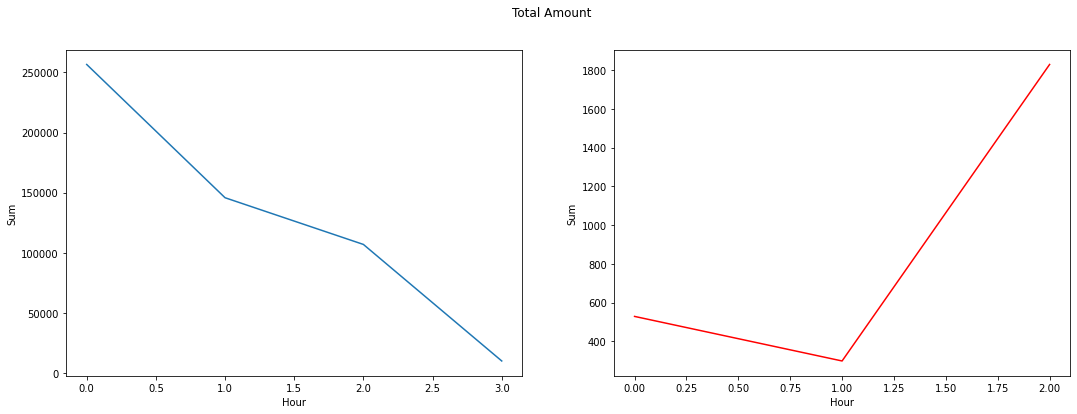

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

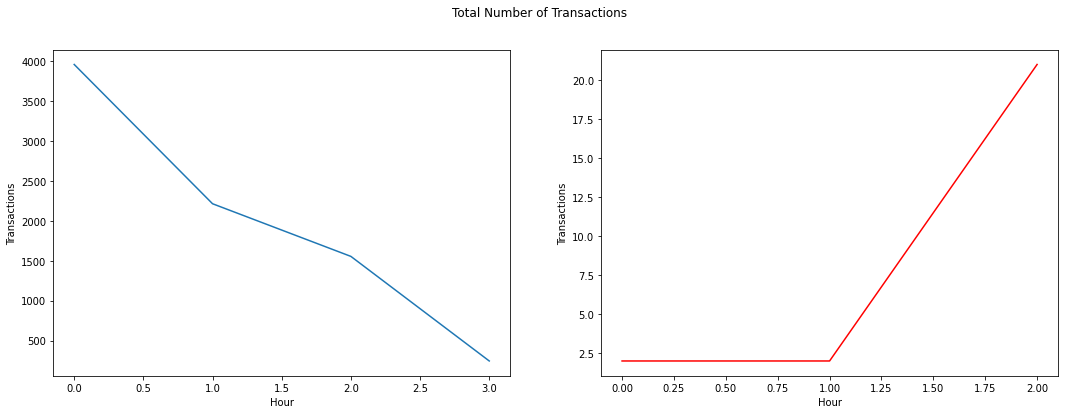

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

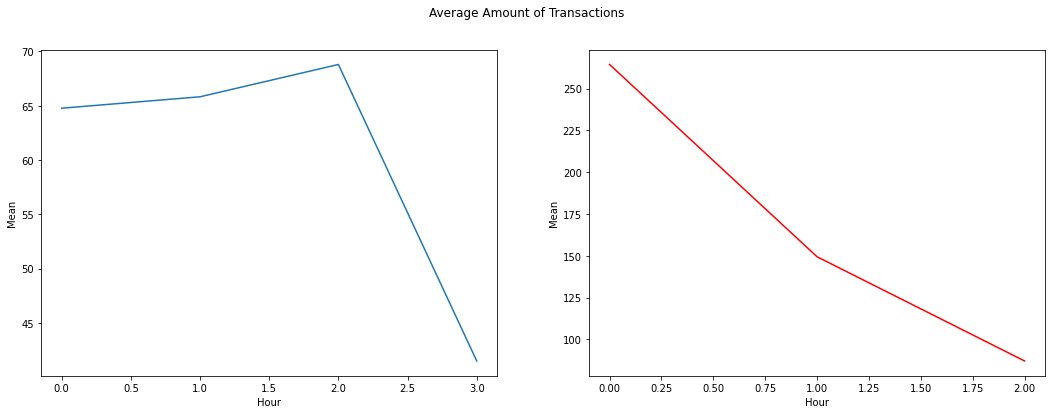

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

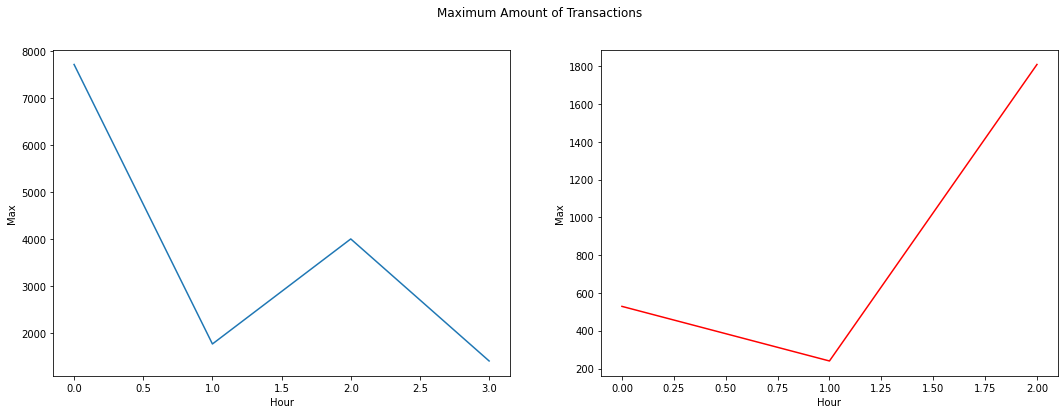

In [37]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

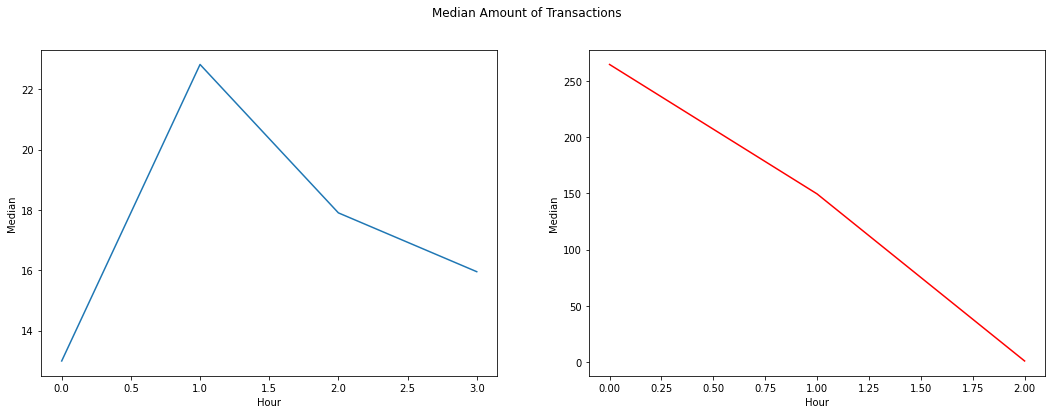

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

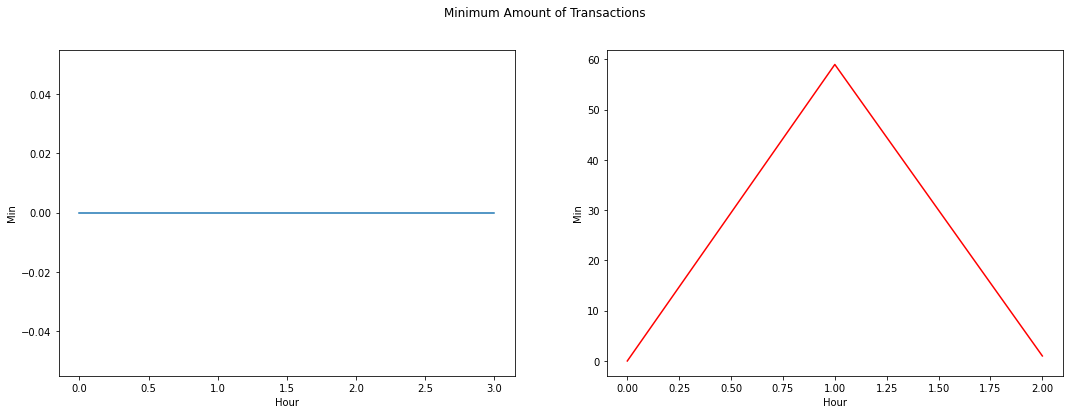

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

#### Transactions amount

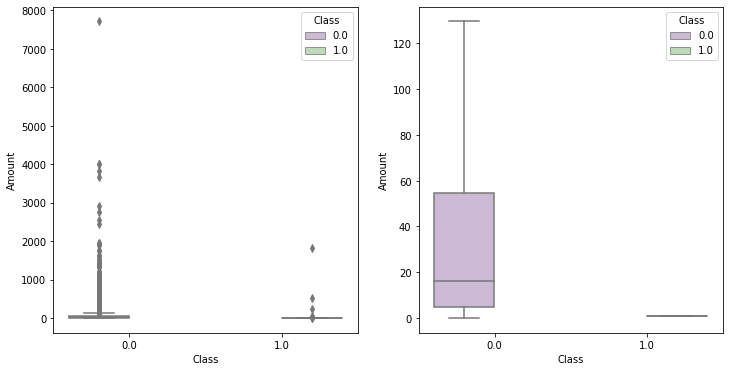

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=creditcard, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=creditcard, palette="PRGn",showfliers=False)
plt.show();

In [41]:
tmp = creditcard[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    7975.000000
mean       65.140361
std       193.808029
min         0.000000
25%         4.865000
50%        15.950000
75%        54.775000
max      7712.430000
Name: Amount, dtype: float64

In [42]:
class_1.describe()

count      25.000000
mean      106.308400
std       372.676883
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1809.680000
Name: Amount, dtype: float64

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers.

Let's plot the fraudulent transactions (amount) against time. The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

In [43]:
# fraud = creditcard.loc[creditcard['Class'] == 1]

# trace = go.Scatter(
#     x = fraud['Time'],y = fraud['Amount'],
#     name="Amount",
#      marker=dict(
#                 color='rgb(238,23,11)',
#                 line=dict(
#                     color='red',
#                     width=1),
#                 opacity=0.5,
#             ),
#     text= fraud['Amount'],
#     mode = "markers"
# )
# data = [trace]
# layout = dict(title = 'Amount of fraudulent transactions',
#           xaxis = dict(title = 'Time [s]', showticklabels=True), 
#           yaxis = dict(title = 'Amount'),
#           hovermode='closest'
#          )
# fig = dict(data=data, layout=layout)
# iplot(fig, filename='fraud-amount')

#### Features correlation

As expected, there is no notable correlation between features V1-V28. There are certain correlations between some of these features and Time (inverse correlation with V3) and Amount (direct correlation with V7 and V20, inverse correlation with V1 and V5).

Let's plot the correlated and inverse correlated values on the same graph.

Let's start with the direct correlated values: {V20;Amount} and {V7;Amount}.

In [ ]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = creditcard.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

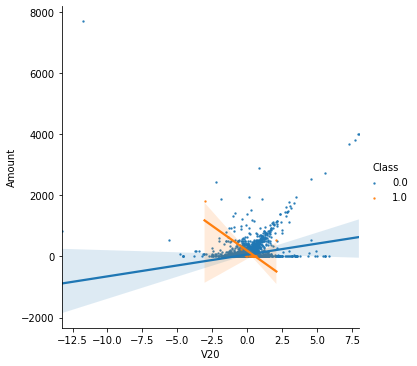

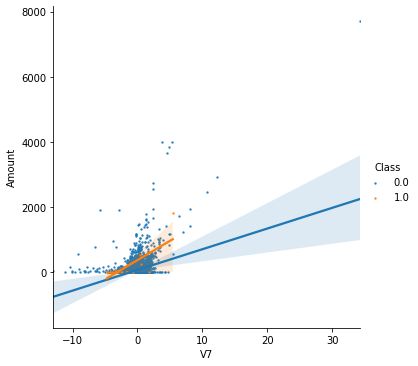

In [45]:
s = sns.lmplot(x='V20', y='Amount',data=creditcard, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=creditcard, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are correlated (the regression lines for Class = 0 have a positive slope, whilst the regression line for Class = 1 have a smaller positive slope).

Let's plot now the inverse correlated values.

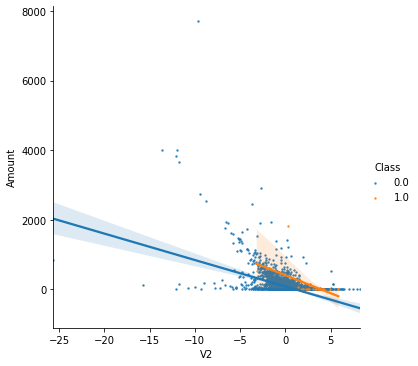

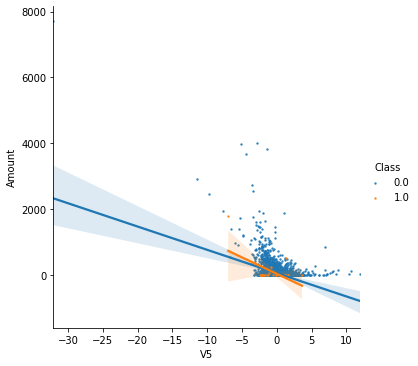

In [46]:
s = sns.lmplot(x='V2', y='Amount',data=creditcard, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=creditcard, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are inverse correlated (the regression lines for Class = 0 have a negative slope while the regression lines for Class = 1 have a very small negative slope).

#### Features density plot

In [47]:
creditcard['V1'] = creditcard['V1'].astype('float')

<Figure size 432x288 with 0 Axes>

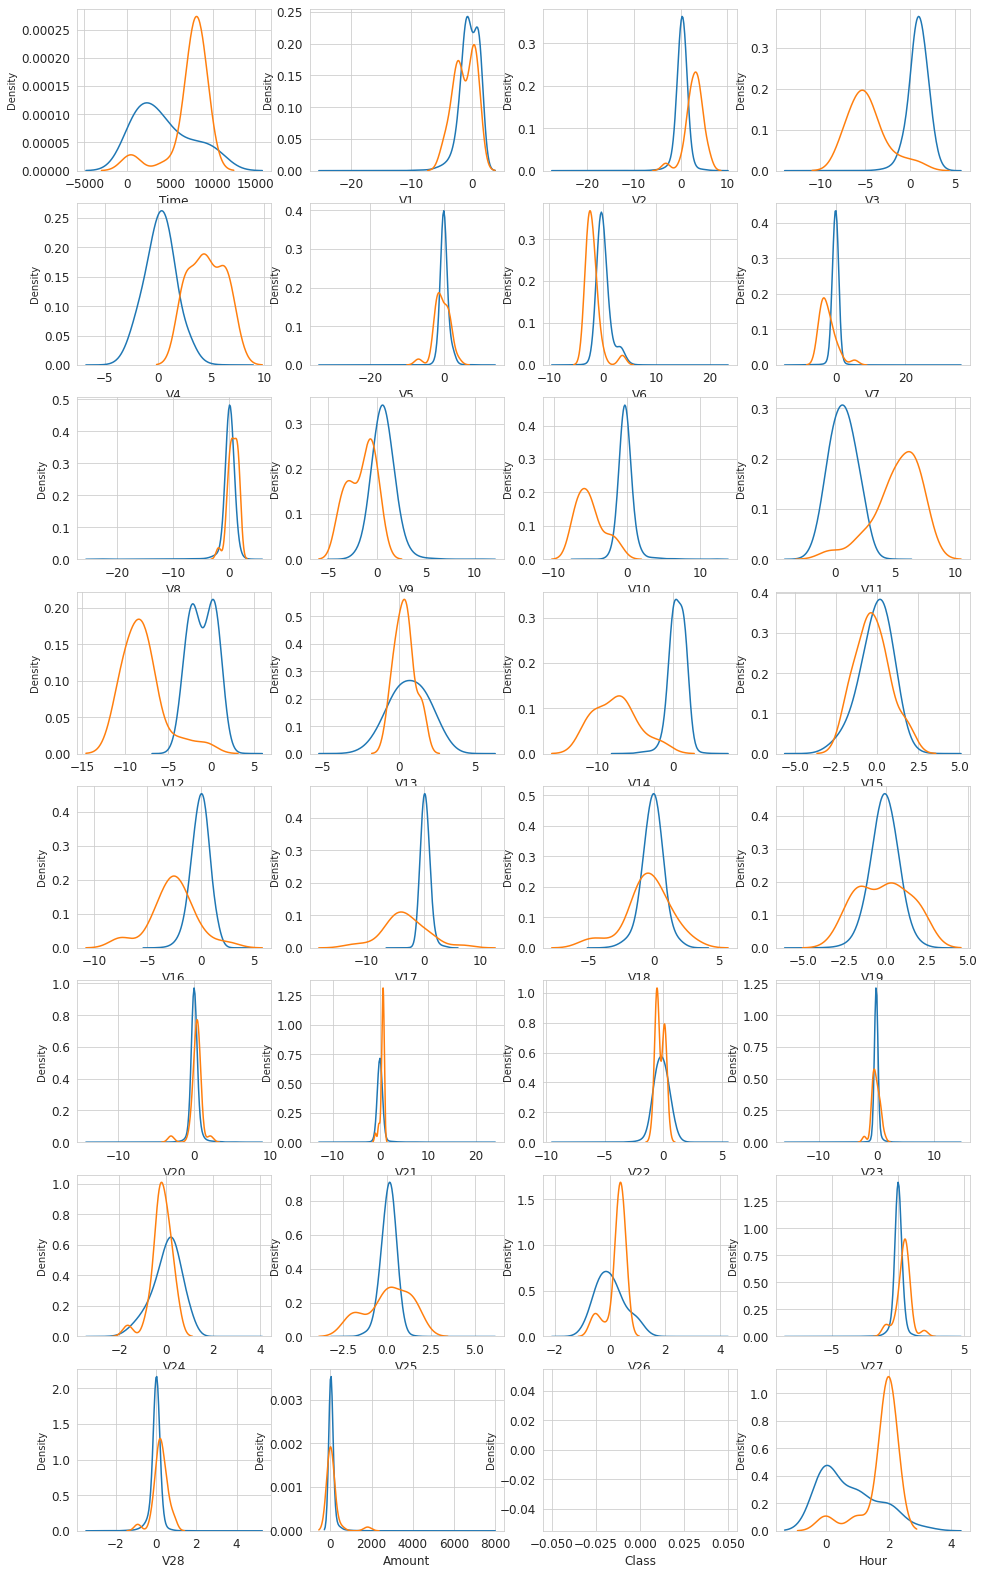

In [48]:
var = creditcard.columns.values

i = 0
t0 = creditcard.loc[creditcard['Class'] == 0]
t1 = creditcard.loc[creditcard['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

For some of the features we can observe a good selectivity in terms of distribution for the two values of Class: V4, V11 have clearly separated distributions for Class values 0 and 1, V12, V14, V18 are partially separated, V1, V2, V3, V10 have a quite distinct profile, whilst V25, V26, V28 have similar profiles for the two values of Class.

In general, with just few exceptions (Time and Amount), the features distribution for legitimate transactions (values of Class = 0) is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of Class = 1) have a skewed (asymmetric) distribution.

## Predictive models
Define predictors and target values
Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [49]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#### Split data in train, test and validation set
Let's define train, validation and test sets.

In [50]:
train_df, test_df = train_test_split(creditcard, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
#train_df, valid_df = train_test_split(creditcard, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [51]:
X_train, X_test = train_df[predictors], test_df[predictors]
y_train, y_test = train_df[target], test_df[target]

## Logistic Regression



In [52]:
with mlflow.start_run(run_name="logistic_regression"):
    clf = LogisticRegression(random_state=0, max_iter=50, l1_ratio=0.8, penalty='elasticnet', solver='saga')
    clf.fit(X_train, y_train)
    

    
    y_pred_tr = clf.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_tr)
    train_accuracy = accuracy_score(y_train, y_pred_tr)
    
    
    y_pred = clf.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    mlflow.log_metric("train_auc", roc_auc_train)
    mlflow.log_metric("test_auc", roc_auc_test)
    
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    mlflow.sklearn.log_model(clf, f"logistic_regression")

2021/07/28 05:32:26 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



In [53]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)

train_accuracy = accuracy_score(y_train,y_pred_tr)

print('\n')
print('\033[1mTraining Accuracy Percentage\033[0m: %.2f' % (train_accuracy*100))

print('\n')
print('\033[1mTesting Accuracy Percentage\033[0m: %.2f' % (accuracy*100))

print('================================================================================================================')
print('\033[1mClassification_report for testing \033[0m')

print(classification_report(y_test, y_pred))

print('\033[1mClassification_report for training \033[0m')

print(classification_report(y_train,y_pred_tr))

print('================================================================================================================')
#print('\033[1mConfusion_Matrix\033[0m')
#confusion_matrix = confusion_matrix(y_test, y_pred)
##group_names = ['True Neg','False Pos','False Neg','True Pos']
#group_counts = ["{0:0.0f}".format(value) for value in
#                confusion_matrix.flatten()]
#group_percentages = ['{0:.2%}'.format(value) for value in
#                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
#
#group_description = ['The person paid on time\n and model also predicted\n paid on time',
#                     'The person paid on time\n and model predicted paid late',
#                    'The person paid late\n and model predicted paid\n on time',
#                     'The person paid late\n and model also predicted\n paid late']
#labels = [f"{v3}\n{v1}\n{v2}" for v1, v2, v3 in
#          zip(group_percentages,group_description,group_counts)]
#labels = np.asarray(labels).reshape(2,2)
#
#fig, ax = plt.subplots(figsize=(9,7))
#sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues',
#            annot_kws={'fontsize':'large','fontweight':'bold'}
#           ,cbar=False,xticklabels=['Predicted on time','Predicted late paid']
#            ,yticklabels=['Actual on time','Actual late paid'])
#
#plt.show()



Training Accuracy Percentage: 99.72


Testing Accuracy Percentage: 99.56
Classification_report for testing 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1593
         1.0       0.00      0.00      0.00         7

    accuracy                           1.00      1600
   macro avg       0.50      0.50      0.50      1600
weighted avg       0.99      1.00      0.99      1600

Classification_report for training 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6382
         1.0       0.00      0.00      0.00        18

    accuracy                           1.00      6400
   macro avg       0.50      0.50      0.50      6400
weighted avg       0.99      1.00      1.00      6400



## GradientBoostingClassifier

In [54]:
with mlflow.start_run(run_name="GradientBoostingClassifier"):
    clf = GradientBoostingClassifier(random_state = 42)
    clf.fit(X_train, y_train)
    

    
    y_pred_tr = clf.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_tr)
    train_accuracy = accuracy_score(y_train, y_pred_tr)
    
    
    y_pred = clf.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    mlflow.log_metric("train_auc", roc_auc_train)
    mlflow.log_metric("test_auc", roc_auc_test)
    
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    mlflow.sklearn.log_model(clf, f"GradientBoostingClassifier")

In [55]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)

train_accuracy = accuracy_score(y_train,y_pred_tr)

print('\n')
print('\033[1mTraining Accuracy Percentage\033[0m: %.2f' % (train_accuracy*100))

print('\n')
print('\033[1mTesting Accuracy Percentage\033[0m: %.2f' % (accuracy*100))

print('================================================================================================================')
print('\033[1mClassification_report for testing \033[0m')

print(classification_report(y_test, y_pred))

print('\033[1mClassification_report for training \033[0m')

print(classification_report(y_train,y_pred_tr))

print('================================================================================================================')





Training Accuracy Percentage: 100.00


Testing Accuracy Percentage: 99.94
Classification_report for testing 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1593
         1.0       1.00      0.86      0.92         7

    accuracy                           1.00      1600
   macro avg       1.00      0.93      0.96      1600
weighted avg       1.00      1.00      1.00      1600

Classification_report for training 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6382
         1.0       1.00      1.00      1.00        18

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400



## RandomForestClassifier

In [56]:
with mlflow.start_run(run_name="RandomForestClassifier"):
    clf = RandomForestClassifier(random_state = 42)
    clf.fit(X_train, y_train)
    

    
    y_pred_tr = clf.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_tr)
    train_accuracy = accuracy_score(y_train, y_pred_tr)
    
    
    y_pred = clf.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    mlflow.log_metric("train_auc", roc_auc_train)
    mlflow.log_metric("test_auc", roc_auc_test)
    
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    mlflow.sklearn.log_model(clf, f"RandomForestClassifier")

In [57]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)

train_accuracy = accuracy_score(y_train,y_pred_tr)

print('\n')
print('\033[1mTraining Accuracy Percentage\033[0m: %.2f' % (train_accuracy*100))

print('\n')
print('\033[1mTesting Accuracy Percentage\033[0m: %.2f' % (accuracy*100))

print('================================================================================================================')
print('\033[1mClassification_report for testing \033[0m')

print(classification_report(y_test, y_pred))

print('\033[1mClassification_report for training \033[0m')

print(classification_report(y_train,y_pred_tr))

print('================================================================================================================')




Training Accuracy Percentage: 100.00


Testing Accuracy Percentage: 99.88
Classification_report for testing 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1593
         1.0       1.00      0.71      0.83         7

    accuracy                           1.00      1600
   macro avg       1.00      0.86      0.92      1600
weighted avg       1.00      1.00      1.00      1600

Classification_report for training 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6382
         1.0       1.00      1.00      1.00        18

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400



## AdaBoostClassifier

In [58]:
with mlflow.start_run(run_name="AdaBoostClassifier"):
    clf = AdaBoostClassifier(random_state = 42)
    clf.fit(X_train, y_train)
    

    
    y_pred_tr = clf.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_tr)
    train_accuracy = accuracy_score(y_train, y_pred_tr)
    
    
    y_pred = clf.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    mlflow.log_metric("train_auc", roc_auc_train)
    mlflow.log_metric("test_auc", roc_auc_test)
    
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    mlflow.sklearn.log_model(clf, f"AdaBoostClassifier")

In [59]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)

train_accuracy = accuracy_score(y_train,y_pred_tr)

print('\n')
print('\033[1mTraining Accuracy Percentage\033[0m: %.2f' % (train_accuracy*100))

print('\n')
print('\033[1mTesting Accuracy Percentage\033[0m: %.2f' % (accuracy*100))

print('================================================================================================================')
print('\033[1mClassification_report for testing \033[0m')

print(classification_report(y_test, y_pred))

print('\033[1mClassification_report for training \033[0m')

print(classification_report(y_train,y_pred_tr))

print('================================================================================================================')




Training Accuracy Percentage: 100.00


Testing Accuracy Percentage: 99.94
Classification_report for testing 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1593
         1.0       1.00      0.86      0.92         7

    accuracy                           1.00      1600
   macro avg       1.00      0.93      0.96      1600
weighted avg       1.00      1.00      1.00      1600

Classification_report for training 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6382
         1.0       1.00      1.00      1.00        18

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400



## CatBoostClassifier

In [60]:
with mlflow.start_run(run_name="CatBoostClassifier"):
    clf = CatBoostClassifier(random_seed = 42)
    clf.fit(X_train, y_train,verbose=True)
    

    
    y_pred_tr = clf.predict(X_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_tr)
    train_accuracy = accuracy_score(y_train, y_pred_tr)
    
    
    y_pred = clf.predict(X_test)
    roc_auc_test = roc_auc_score(y_test, y_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    mlflow.log_metric("train_auc", roc_auc_train)
    mlflow.log_metric("test_auc", roc_auc_test)
    
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    mlflow.sklearn.log_model(clf, f"CatBoostClassifier")

Learning rate set to 0.02276
0:	learn: 0.6291003	total: 54.4ms	remaining: 54.4s
1:	learn: 0.5707037	total: 60.6ms	remaining: 30.3s
2:	learn: 0.5080690	total: 67.2ms	remaining: 22.3s
3:	learn: 0.4540612	total: 72.8ms	remaining: 18.1s
4:	learn: 0.4055271	total: 80ms	remaining: 15.9s
5:	learn: 0.3617556	total: 86.1ms	remaining: 14.3s
6:	learn: 0.3262129	total: 92.4ms	remaining: 13.1s
7:	learn: 0.2969343	total: 98.4ms	remaining: 12.2s
8:	learn: 0.2676490	total: 104ms	remaining: 11.5s
9:	learn: 0.2374068	total: 112ms	remaining: 11.1s
10:	learn: 0.2126402	total: 120ms	remaining: 10.8s
11:	learn: 0.1920981	total: 129ms	remaining: 10.6s
12:	learn: 0.1724236	total: 136ms	remaining: 10.4s
13:	learn: 0.1555984	total: 144ms	remaining: 10.2s
14:	learn: 0.1400945	total: 151ms	remaining: 9.89s
15:	learn: 0.1264562	total: 156ms	remaining: 9.6s
16:	learn: 0.1152455	total: 162ms	remaining: 9.37s
17:	learn: 0.1053827	total: 168ms	remaining: 9.16s
18:	learn: 0.0940581	total: 174ms	remaining: 8.99s
19:	lea

In [61]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)

train_accuracy = accuracy_score(y_train,y_pred_tr)

print('\n')
print('\033[1mTraining Accuracy Percentage\033[0m: %.2f' % (train_accuracy*100))

print('\n')
print('\033[1mTesting Accuracy Percentage\033[0m: %.2f' % (accuracy*100))

print('================================================================================================================')
print('\033[1mClassification_report for testing \033[0m')

print(classification_report(y_test, y_pred))

print('\033[1mClassification_report for training \033[0m')

print(classification_report(y_train,y_pred_tr))

print('================================================================================================================')




Training Accuracy Percentage: 100.00


Testing Accuracy Percentage: 99.88
Classification_report for testing 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1593
         1.0       1.00      0.71      0.83         7

    accuracy                           1.00      1600
   macro avg       1.00      0.86      0.92      1600
weighted avg       1.00      1.00      1.00      1600

Classification_report for training 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6382
         1.0       1.00      1.00      1.00        18

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400



## Select the run of the experiment

In [62]:

df_runs = mlflow.search_runs(experiment_ids=exp_id)
print("Number of runs done : ", len(df_runs))
print(df_runs)

Number of runs done :  22
                              run_id experiment_id    status  \
0   25d2476ebbdd40368f158d524baa321d            73  FINISHED   
1   0ac41eeb9a204c2eb593f8c725ae635e            73  FINISHED   
2   73c1c00edf12436e8d3d29a810716a49            73  FINISHED   
3   707f40bad8fb4e4e93c67c40d2d9cdbd            73  FINISHED   
4   c56519b5a0264726b0b44a5e328b61b2            73  FINISHED   
5   d8bfb00fb6af452a95d7d68ed1f80eb5            73    FAILED   
6   b4c9bca96785417091053d766ab1f58f            73  FINISHED   
7   b03e44f22bfe4319aa431a10bb279c40            73  FINISHED   
8   151871828f204a43b7cfba31e985ae8e            73  FINISHED   
9   7213fd608ef34cc998000d5f24052c55            73  FINISHED   
10  e0351687988041b2b799f3377b089927            73  FINISHED   
11  b2d2728e57804fd9a5aaf1a9efd1bce2            73  FINISHED   
12  90d88c48e80b43b687306dfaedaa7b3a            73  FINISHED   
13  4fa28785cb114d938776509521fd49ff            73  FINISHED   
14  b194767705

## Evaluating  Models

In [63]:
top_runs = df_runs.sort_values(['metrics.test_auc'],ascending=False)
top_runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_auc,metrics.test_accuracy,metrics.train_accuracy,metrics.test_auc,tags.mlflow.runName,tags.mlflow.source.type,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name
1,0ac41eeb9a204c2eb593f8c725ae635e,73,FINISHED,s3://models/73/0ac41eeb9a204c2eb593f8c725ae635...,2021-07-28 05:32:34.791000+00:00,2021-07-28 05:32:36.487000+00:00,1.0,0.999375,1.0,0.928571,AdaBoostClassifier,LOCAL,"[{""run_id"": ""0ac41eeb9a204c2eb593f8c725ae635e""...",root,/opt/miniconda/lib/python3.7/site-packages/ipy...
3,707f40bad8fb4e4e93c67c40d2d9cdbd,73,FINISHED,s3://models/73/707f40bad8fb4e4e93c67c40d2d9cdb...,2021-07-28 05:32:27.428000+00:00,2021-07-28 05:32:33.432000+00:00,1.0,0.999375,1.0,0.928571,GradientBoostingClassifier,LOCAL,"[{""run_id"": ""707f40bad8fb4e4e93c67c40d2d9cdbd""...",root,/opt/miniconda/lib/python3.7/site-packages/ipy...
7,b03e44f22bfe4319aa431a10bb279c40,73,FINISHED,s3://models/73/b03e44f22bfe4319aa431a10bb279c4...,2021-07-28 03:59:56.020000+00:00,2021-07-28 03:59:57.602000+00:00,1.0,0.999375,1.0,0.928571,AdaBoostClassifier,LOCAL,"[{""run_id"": ""b03e44f22bfe4319aa431a10bb279c40""...",root,/opt/miniconda/lib/python3.7/site-packages/ipy...
9,7213fd608ef34cc998000d5f24052c55,73,FINISHED,s3://models/73/7213fd608ef34cc998000d5f24052c5...,2021-07-28 03:59:37.021000+00:00,2021-07-28 03:59:42.460000+00:00,1.0,0.999375,1.0,0.928571,GradientBoostingClassifier,LOCAL,"[{""run_id"": ""7213fd608ef34cc998000d5f24052c55""...",root,/opt/miniconda/lib/python3.7/site-packages/ipy...
11,b2d2728e57804fd9a5aaf1a9efd1bce2,73,FINISHED,s3://models/73/b2d2728e57804fd9a5aaf1a9efd1bce...,2021-07-28 03:53:10.353000+00:00,2021-07-28 03:53:16.354000+00:00,1.0,0.999375,1.0,0.928571,GradientBoostingClassifier,LOCAL,"[{""run_id"": ""b2d2728e57804fd9a5aaf1a9efd1bce2""...",root,/opt/miniconda/lib/python3.7/site-packages/ipy...


## Selecting best model

In [65]:
artifacts = top_runs.iloc[0]["artifact_uri"]
run_id = top_runs.iloc[0]["run_id"]
model_name = top_runs.iloc[0]["tags.mlflow.runName"] 


print('Best model_artifacts :',artifacts)
print("=" * 100)
print('Best model run_id :',run_id)
print("=" * 100)
print('Best model :',model_name)
print("=" * 100)
print("Best model experiment id :",exp_id)

Best model_artifacts : s3://models/73/0ac41eeb9a204c2eb593f8c725ae635e/artifacts
Best model run_id : 0ac41eeb9a204c2eb593f8c725ae635e
Best model : AdaBoostClassifier
Best model experiment id : 73


## Registering best model

In [67]:
result = mlflow.register_model(
    "runs:/" + run_id,
    MODEL_NAME+'_'+model_name
)

Registered model 'cred_fraud_detection-model_AdaBoostClassifier' already exists. Creating a new version of this model...
2021/07/28 05:32:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cred_fraud_detection-model_AdaBoostClassifier, version 2
Created version '2' of model 'cred_fraud_detection-model_AdaBoostClassifier'.


In [68]:
print('Registered model information :')
print('=='*50)
print(pd.DataFrame(result, columns =['Attribute','Value']))

Registered model information :
                 Attribute                                              Value
0       creation_timestamp                                      1627450364696
1            current_stage                                               None
2              description                                                   
3   last_updated_timestamp                                      1627450364696
4                     name      cred_fraud_detection-model_AdaBoostClassifier
5                   run_id                   0ac41eeb9a204c2eb593f8c725ae635e
6                 run_link                                                   
7                   source  s3://models/73/0ac41eeb9a204c2eb593f8c725ae635...
8                   status                                              READY
9           status_message                                                   
10                    tags                                                 {}
11                 user_id       

In [69]:
print('Experiment information :')
print('=='*50)
print(pd.DataFrame(exp_details, columns =['Attribute','Value']))

Experiment information :
           Attribute                        Value
0  artifact_location               s3://models/73
1      experiment_id                           73
2    lifecycle_stage                       active
3               name  credit-card-fraud-detection
4               tags                           {}


## storing best model address for deployment

In [70]:

time = pd.to_datetime(datetime.now())

In [71]:
dictionary = [{"model":model_name,
             "location":artifacts+'/'+model_name,
             "run_id":run_id,
            'experiment_id':exp_id,
              'prod_time':time,
              'top_features':predictors,
              }]

In [72]:
dataset = pd.DataFrame(dictionary)
dataset

,model,location,run_id,experiment_id,prod_time,top_features
0,AdaBoostClassifier,s3://models/73/0ac41eeb9a204c2eb593f8c725ae635...,0ac41eeb9a204c2eb593f8c725ae635e,73,2021-07-28 05:32:44.756239,"[Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10..."


In [ ]:
POSTGRES_PASSWORD = passwrd_parser(POSTGRES_PASSWORD)

In [73]:
write_to_feature_store(POSTGRES_USERNAME,POSTGRES_PASSWORD,POSTGRES_ADDRESS,
                       POSTGRES_PORT,POSTGRES_DBNAME,PROJECT_SCHEMA,dataset,TABLE_MODEL)